In [ ]:
import pandas as pd
import re
import spacy
from gensim.models import Word2Vec
from nltk.corpus import stopwords
from collections import defaultdict
from transformers import BertTokenizerFast
from sklearn.model_selection import train_test_split
import torch
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from transformers import BertTokenizerFast
from transformers import BertForTokenClassification, BertTokenizerFast
from transformers import get_scheduler
from torch.optim import AdamW
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import RobertaTokenizer, RobertaForSequenceClassification
import pandas as pd
from sklearn.metrics import accuracy_score

# Aspect Seed Expansion Using Word2Vec.

Train In-Domain Word2Vec on Uber Reviews

-------------------------------------------------------------------------------------------------------------------

In-Domain Dataset Size

Smaller datasets are more prone to overfitting and noise with large embedding sizes.

100 dimensions is a balanced tradeoff:

Enough to capture meaning

Not too high to overfit or produce noisy vectors

In [ ]:



df = pd.read_csv("uber_reviews_without_reviewid.csv")


def tokenize(text):
    return re.findall(r"\w+", str(text).lower())

sentences = df["content"].dropna().apply(tokenize).tolist()

# Training Word2Vec
w2v_model = Word2Vec(
    sentences,
    vector_size=200, 
    window=10,
    min_count=2,
    workers=4,
    sg=1  
)


w2v_model.save("uber_reviews_word2vec.model")


In [3]:
df

,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,User_0,NaN,Good,5,0,4.556.10005,2024-12-18 17:17:19,NaN,NaN,4.556.10005
1,User_1,NaN,Nice,5,0,4.556.10005,2024-12-18 17:17:17,NaN,NaN,4.556.10005
2,User_2,NaN,Very convenient,5,0,4.532.10001,2024-12-18 17:09:42,NaN,NaN,4.532.10001
3,User_3,NaN,Good,4,0,4.556.10005,2024-12-18 17:08:27,NaN,NaN,4.556.10005
4,User_4,NaN,exllence,5,0,4.556.10005,2024-12-18 17:08:16,NaN,NaN,4.556.10005
...,...,...,...,...,...,...,...,...,...,...
11995,User_11995,NaN,Excellent!!!,5,0,4.553.10000,2024-11-24 21:59:16,NaN,NaN,4.553.10000
11996,User_11996,NaN,Worst experience after 10pm in Hyde cityno aut...,5,0,4.552.10000,2024-11-24 21:56:10,NaN,NaN,4.552.10000
11997,User_11997,NaN,Exceptional,5,0,4.552.10000,2024-11-24 21:52:21,NaN,NaN,4.552.10000
11998,User_11998,NaN,Good Service.,5,0,4.553.10000,2024-11-24 21:50:30,NaN,NaN,4.553.10000


# Expand Aspect Seeds Using the Trained Model

In [4]:
!python -m spacy download en_core_web_sm


     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     -- ------------------------------------- 0.8/12.8 MB 8.5 MB/s eta 0:00:02
     ---------- ----------------------------- 3.4/12.8 MB 11.2 MB/s eta 0:00:01
     ------------- -------------------------- 4.5/12.8 MB 10.0 MB/s eta 0:00:01
     -------------- ------------------------- 4.7/12.8 MB 8.9 MB/s eta 0:00:01
     -------------- ------------------------- 4.7/12.8 MB 8.9 MB/s eta 0:00:01
     --------------- ------------------------ 5.0/12.8 MB 4.4 MB/s eta 0:00:02
     ---------------------- ----------------- 7.1/12.8 MB 5.3 MB/s eta 0:00:02
     --------------------------- ------------ 8.9/12.8 MB 6.2 MB/s eta 0:00:01
     ---------------------------------- ----- 11.0/12.8 MB 6.4 MB/s eta 0:00:01
     ------------------------------------ --- 11.5/12.8 MB 6.0 MB/s eta 0:00:01
     ---------------------------------------- 12.8/12.8 MB 6.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now loa

# USING SPACY FOR POS -TAGGING AND DEFINING ASPECT SEEDS BASED ON THE MOST FREQUENTLY USED ASPECTS 


In [ ]:



nlp = spacy.load("en_core_web_sm")
stop_words = set(stopwords.words("english"))

w2v_model = Word2Vec.load("uber_reviews_word2vec.model")

aspect_seeds = [
    "driver", "ride", "app", "fare", "support", "payment",
    "booking",  "car", "interface", "service",
    "map", "location", "tracking", "navigation", "speed",
     "refund", "issue", "experience",
    "agent", "customer", "drop", "pickup", "wallet", "route",
    "destination", "delay", "wait","uber"
]





In [ ]:
def is_noun(word):
    doc = nlp(word)
    return len(doc) > 0 and doc[0].pos_ == "NOUN"

def is_valid_word(word):
    return word.isalpha() and word not in stop_words and is_noun(word)

def gap_cutoff_filter(similar_list, drop_threshold=0.05):
    filtered = []
    for i in range(1, len(similar_list)):
        if similar_list[i-1][1] - similar_list[i][1] > drop_threshold:
            return similar_list[:i]
    return similar_list

# USING COSINE SIMILARITY WITH A SIMILARITY THRESHOLD OF >0.75 TO MAP WORDS TO SIMILAR ASPECTS BASED ON THE DEFINED ASPECT SEEDS

In [ ]:
similar_words_map = defaultdict(list)
similarity_threshold = 0.75
topn = 10

for seed in aspect_seeds:
    if seed not in w2v_model.wv:
        continue
    similar_raw = w2v_model.wv.most_similar(seed, topn=topn)
    filtered = [(w, s) for w, s in similar_raw if s >= similarity_threshold and is_valid_word(w)]
    filtered = gap_cutoff_filter(filtered)
    similar_words_map[seed] = filtered

rows = []
for seed, pairs in similar_words_map.items():
    for word, sim in pairs:
        rows.append({"aspect_seed": seed, "similar_word": word, "similarity": sim})

expanded_df = pd.DataFrame(rows)



In [7]:
for seed in aspect_seeds:
    if seed in w2v_model.wv:
        similar = w2v_model.wv.most_similar(seed, topn=10)
        print(f"\n{seed.upper()} → {[f'{word} ({round(score, 3)})' for word, score in similar]}")
    else:
        print(f"{seed} not in vocab.")


DRIVER → ['car (0.845)', 'man (0.811)', 'trip (0.805)', 'he (0.804)', 'drive (0.803)', 'luggage (0.797)', 'ride (0.785)', 'came (0.785)', 'person (0.782)', 'pickup (0.781)']

RIDE → ['trip (0.898)', 'coming (0.816)', 'night (0.815)', 'bike (0.815)', 'once (0.814)', 'arrival (0.814)', 'completing (0.812)', 'confirmation (0.809)', 'accepted (0.808)', 'confirm (0.807)']

APP → ['application (0.833)', 'system (0.73)', 'books (0.722)', 'platform (0.721)', 'diver (0.719)', 'company (0.717)', 'ever (0.717)', 'install (0.717)', 'trust (0.712)', 'seen (0.712)']

FARE → ['shown (0.951)', 'reaching (0.935)', 'booking (0.93)', 'increased (0.928)', 'fair (0.925)', 'shows (0.924)', 'double (0.923)', 'showing (0.923)', 'increase (0.919)', 'different (0.918)']

SUPPORT → ['chat (0.918)', 'team (0.908)', 'contact (0.907)', 'proper (0.894)', 'help (0.891)', 'care (0.887)', 'customer (0.881)', 'number (0.874)', 'ai (0.873)', 'mail (0.865)']

PAYMENT → ['upi (0.927)', 'method (0.893)', 'cash (0.891)', 'o

In [ ]:

canonical_aspects = [
    "driver", "ride", "app", "fare", "support", "payment",
    "booking",  "car", "interface", "service",
    "map", "location", "tracking", "navigation", "speed",
     "refund", "issue", "experience",
    "agent", "customer", "drop", "pickup", "wallet", "route",
    "destination", "delay", "wait","uber"
]


similarity_threshold = 0.75

aspect_mapping = defaultdict(lambda: None)

for canon in canonical_aspects:
    aspect_mapping[canon] = canon  
    similar_words =w2v_model.wv.most_similar(canon, topn=10)
    for word, score in similar_words:
        if score > similarity_threshold:
            aspect_mapping[word] = canon


In [9]:
for word, mapped_to in aspect_mapping.items():
    print(f"{word} → {mapped_to}")


driver → driver
car → car
man → car
trip → ride
he → driver
drive → driver
luggage → car
ride → ride
came → pickup
person → car
pickup → pickup
coming → ride
night → ride
bike → ride
once → ride
arrival → route
completing → ride
confirmation → ride
accepted → ride
confirm → ride
app → app
application → experience
fare → booking
shown → booking
reaching → destination
booking → booking
increased → booking
fair → booking
shows → booking
double → fare
showing → fare
increase → booking
different → fare
support → customer
chat → customer
team → customer
contact → support
proper → customer
help → customer
care → customer
customer → customer
number → support
ai → customer
mail → issue
payment → payment
upi → wallet
method → payment
cash → payment
online → payment
mode → wallet
wallet → wallet
add → payment
pending → wallet
digital → wallet
fraud → payment
while → booking
changes → route
initially → booking
drove → car
safely → car
conversation → car
helped → car
guy → car
gentleman → car
music

In [ ]:

mapping_df = pd.DataFrame(list(aspect_mapping.items()), columns=["Original_Word", "Mapped_Aspect"])
mapping_df.to_csv("aspect_mappings.csv", index=False)


# MANUALLY EDITING THE ASPECT MAPPINGS ON TOP OF COSINE SIM. FOR PRECISED MAPPINGS AND BETTER EVALUATION

In [ ]:
# manually edited file
refined_df = pd.read_csv("updated_aspect_mappings.csv")


aspect_mapping = dict(zip(refined_df["Original_Word"], refined_df["Mapped_Aspect"]))


PRECISED NORMALISATION (ASPECT MAPPING) 

In [12]:
for word, mapped_to in aspect_mapping.items():
    print(f"{word} → {mapped_to}")

driver → driver
car → car
trip → ride
ride → ride
journey → car
she → car
vehicle → car
drive → driver
drove → driver
arrived → wait
rider → driver
bike → car
request → ride
destination → destination
confirmation → ride
increased → fare
rides → ride
app → app
application → app
company → app
experience → experience
aap → app
platform → uber
seen → -
ever → app
services → service
life → experience
travel → service
fare → fare
booking → booking
shown → fare
increase → fare
showing → fare
shows → fare
while → ride
reaching → destination
double → booking
fair → fare
changes → route
support → support
number → customer
contact → support
proper → support
care → support
team → support
help → support
chat → support
customer → customer
issues → support
provide → service
payment → payment
cash → payment
upi → payment
method → payment
online → payment
amount → payment
pending → payment
which → -
mode → payment
wallet → payment
add → payment
price → fare
cab → car
auto → car
booked → booking
initial

In [ ]:
expanded_df.to_csv("refined_expanded_aspect_seeds.csv", index=False)


In [13]:
bert_df = pd.read_csv("bert_extracted_with_sentiment.csv")

In [14]:
bert_df["predicted_aspects"]

0                uber
1                uber
2                uber
3                uber
4                uber
             ...     
19054      experience
19055            app,
19056         problem
19057    application.
19058        location
Name: predicted_aspects, Length: 19059, dtype: object

In [15]:
bert_df["Normalized_Aspect"] = bert_df["predicted_aspects"].apply(lambda x: aspect_mapping.get(x, x))

In [17]:
bert_df["Normalized_Aspect"]

0                uber
1                uber
2                uber
3                uber
4                uber
             ...     
19054      experience
19055            app,
19056         support
19057    application.
19058            drop
Name: Normalized_Aspect, Length: 19059, dtype: object

In [19]:
bert_df.to_csv("bert_extracted_with_sentiment2.csv")

---------------------------------------------------------------------------------------------------------------------

# ABSA - ASPECT BASED SENTIMENT ANALYSIS

1- WHAT,HOW AND WHY -TRIPLET EXTRACTION

2- ASPECT EXTRACTION USING BERT AND SENTIMENT ANALYSIS USING ROBERT

3- CONTRASTIVE ATTENTION METHOD


# 1- WHAT,HOW AND WHY -TRIPLET EXTRACTION

(What, How, Why)
 = (Aspect, Opinion, Explanation)



In [12]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

##  Initialize sentiment analyzer


In [ ]:
analyzer = SentimentIntensityAnalyzer()

In [14]:
reviews = df['content'].dropna().tolist()

## Aspect Term Extraction (Nouns) 

In [ ]:
def preprocess_review(text):
    return nlp(text.lower())


def extract_aspect_terms(doc):
    return [token.text for token in doc if token.pos_ == "NOUN" and not token.is_stop]

## Opinion Term Extraction (Adj/Verb modifiers) 

In [ ]:

def extract_opinion_terms(doc):
    opinions = []
    for token in doc:
        if token.pos_ in ["ADJ", "VERB"] and token.dep_ in ["amod", "acomp", "xcomp"]:
            opinions.append(token.text)
    return opinions

## Sentiment Classification 

In [ ]:

def get_sentiment(opinion):
    score = analyzer.polarity_scores(opinion)["compound"]
    if score > 0.05:
        return "positive"
    elif score < -0.05:
        return "negative"
    else:
        return "neutral"

## TRIPLET FORMATION

In [ ]:
def build_triplets(doc):
    aspects = extract_aspect_terms(doc)
    opinions = extract_opinion_terms(doc)
    triplets = []
    for asp in aspects:
        for op in opinions:
            if abs(doc.text.find(asp) - doc.text.find(op)) < 15:
                sentiment = get_sentiment(op)
                triplets.append((asp, sentiment, op))
    return triplets

all_triplets = []

In [17]:
for review in reviews:
    doc = preprocess_review(review)
    triplets = build_triplets(doc)
    all_triplets.extend([(review, *t) for t in triplets])

In [ ]:
triplet_df = pd.DataFrame(all_triplets, columns=["Review", "Aspect", "Sentiment", "Opinion"])


In [21]:
triplet_df.to_csv("uber_sentiment_triplets.csv", index=False)
print("Aspect-Sentiment-Opinion triplets extracted and saved.")

Aspect-Sentiment-Opinion triplets extracted and saved.


In [19]:
triplet_df

,Review,Aspect,Sentiment,Opinion
0,Michelle was a very friendly and personable pe...,person,positive,friendly
1,Bast price pr car available,price,neutral,available
2,Bast price pr car available,pr,neutral,available
3,Bast price pr car available,car,neutral,available
4,Good service,service,positive,good
...,...,...,...,...
13888,"Very bad experience with this app, booked a sh...",experience,negative,bad
13889,"Very bad experience with this app, booked a sh...",app,neutral,short
13890,"Very bad experience with this app, booked a sh...",ride,neutral,short
13891,"Very bad experience with this app, booked a sh...",ride,neutral,50rs


## Normalize aspects using the mapping


In [ ]:
triplet_df["Normalized_Aspect"] = triplet_df["Aspect"].apply(lambda x: aspect_mapping.get(x, x))


KeyError: 'Aspect'

## For evaluation and downstream processing


In [ ]:
triplet_df["Aspect"] = triplet_df["Normalized_Aspect"]
triplet_df.drop(columns=["Normalized_Aspect"], inplace=True)

In [22]:
triplet_df.columns = triplet_df.columns.str.lower()

In [23]:
triplet_df

,review,aspect,sentiment,opinion
0,Michelle was a very friendly and personable pe...,driver,positive,friendly
1,Bast price pr car available,fare,neutral,available
2,Bast price pr car available,pr,neutral,available
3,Bast price pr car available,car,neutral,available
4,Good service,service,positive,good
...,...,...,...,...
13888,"Very bad experience with this app, booked a sh...",experience,negative,bad
13889,"Very bad experience with this app, booked a sh...",app,neutral,short
13890,"Very bad experience with this app, booked a sh...",ride,neutral,short
13891,"Very bad experience with this app, booked a sh...",ride,neutral,50rs


In [80]:
triplet_df.to_csv("triplet_extraction_vader",index=True)

## LOADING THE MANUALLY ASPECT EXTRACTED DATASET FOR EVALUATION

In [25]:
gold_df = pd.read_csv("Gold_Standard__Only_B-ASP_Considered_.csv")

In [26]:
gold_df

,review,aspect,sentiment,opinion
0,"Efficient, driver is professional, cost is rea...",driver,positive,friendly/nice/polite
1,"Efficient, driver is professional, cost is rea...",fare,positive,cheap/reasonable
2,Waiting charge is extra bad experience,wait,negative,waiting
3,Good service,service,positive,good/great/nice
4,Worst customer service On 19/11/24 I booked an...,driver,neutral,NaN
...,...,...,...,...
104,Don't install this uber app.. totally waste of...,driver,neutral,NaN
105,Don't install this uber app.. totally waste of...,app,neutral,NaN
106,Don't install this uber app.. totally waste of...,service,negative,bad/poor/worst
107,make app user friendly.one can understand easily,app,neutral,NaN


### evaluating aspect extraction

In [27]:
gold_df["aspect"] = gold_df["aspect"].apply(lambda x: aspect_mapping.get(x, x))

In [28]:
gold_df

,review,aspect,sentiment,opinion
0,"Efficient, driver is professional, cost is rea...",driver,positive,friendly/nice/polite
1,"Efficient, driver is professional, cost is rea...",fare,positive,cheap/reasonable
2,Waiting charge is extra bad experience,wait,negative,waiting
3,Good service,service,positive,good/great/nice
4,Worst customer service On 19/11/24 I booked an...,driver,neutral,NaN
...,...,...,...,...
104,Don't install this uber app.. totally waste of...,driver,neutral,NaN
105,Don't install this uber app.. totally waste of...,app,neutral,NaN
106,Don't install this uber app.. totally waste of...,service,negative,bad/poor/worst
107,make app user friendly.one can understand easily,app,neutral,NaN


In [29]:
from collections import defaultdict
from sklearn.metrics import precision_score, recall_score, f1_score

# Group aspects by review
def group_aspects_by_review(df):
    grouped = defaultdict(set)
    for _, row in df.iterrows():
        grouped[row["review"]].add(row["aspect"].lower())  # normalize case
    return grouped

# Gold and predicted groupings
gold_aspects = group_aspects_by_review(gold_df)
pred_aspects = group_aspects_by_review(triplet_df)


In [30]:
true_positives = 0
false_positives = 0
false_negatives = 0

for review in gold_aspects:
    gold_set = gold_aspects[review]
    pred_set = pred_aspects.get(review, set())

    true_positives += len(gold_set & pred_set)
    false_positives += len(pred_set - gold_set)
    false_negatives += len(gold_set - pred_set)


# EVALUATION OF POS-TAGGER FOR ASPECT EXTRACTION

In [31]:
precision = true_positives / (true_positives + false_positives + 1e-10)
recall = true_positives / (true_positives + false_negatives + 1e-10)
f1 = 2 * precision * recall / (precision + recall + 1e-10)

print(f"Aspect Extraction Evaluation:\nPrecision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}")


Aspect Extraction Evaluation:
Precision: 0.366, Recall: 0.486, F1: 0.417



## Precision: 0.366, Recall: 0.486, F1: 0.417

In [32]:
error_cases = []

for review in gold_aspects:
    gold_set = gold_aspects[review]
    pred_set = pred_aspects.get(review, set())

    false_positives = pred_set - gold_set
    false_negatives = gold_set - pred_set

    if false_positives or false_negatives:
        error_cases.append({
            "review": review,
            "gold_aspects": list(gold_set),
            "predicted_aspects": list(pred_set),
            "false_positives": list(false_positives),
            "false_negatives": list(false_negatives)
        })


In [ ]:
import pandas as pd

error_df = pd.DataFrame(error_cases)
from IPython.display import display
display(error_df.head(10))  


,review,gold_aspects,predicted_aspects,false_positives,false_negatives
0,Waiting charge is extra bad experience,[wait],"[experience, charge]","[experience, charge]",[wait]
1,Worst customer service On 19/11/24 I booked an...,"[driver, service, app]","[ride, customer, cancellation, fee, app]","[ride, customer, fee, cancellation]","[driver, service]"
2,Reliable and timescale and easy tovl use with ...,[fare],"[fare, tovl]",[tovl],[]
3,Always a pleasure to ride with Uber drivers. Q...,[driver],"[driver, ups, pick]","[ups, pick]",[]
4,Good service...,[service],[],[],[service]
5,Quick service on a busy Friday evening.,[service],"[service, evening]",[evening],[]
6,It is a cheating app. While booking the ride i...,"[driver, fare, app]",[app],[],"[driver, fare]"
7,I love that app,[app],[],[],[app]
8,Even single star is waste... Driver will not l...,[driver],"[time, 10min, fee, star]","[time, 10min, fee, star]",[driver]
9,"1st time using the app, enjoyed the discussion...","[driver, service, app]","[time, uber, service, workings]","[time, uber, workings]","[driver, app]"


---------------------------------------------------------------------------------------------------------------------------------------

# Method 2: BERT-Based Aspect Extraction + RoBERTa-Based Sentiment Classification

 Phase 1: Aspect Extraction using BERT
 
Identify which words in a review are aspects, using BIO tagging.

## preparing BIO labelled data

In [ ]:
import re


df2 = pd.read_csv("uber_reviews_without_reviewid.csv").dropna(subset=["content"])

expanded = pd.read_csv("refined_expanded_aspect_seeds.csv")
aspect_vocab = set(expanded["similar_word"].tolist()) | set(expanded["aspect_seed"].tolist())

def tokenize(text):
    return re.findall(r"\w+", str(text).lower())

def bio_tag_tokens(text, aspect_list):
    tokens = tokenize(text)
    tags = ["O"] * len(tokens)

    for i in range(len(tokens)):
        for phrase in aspect_list:
            phrase_tokens = phrase.split()
            if tokens[i:i+len(phrase_tokens)] == phrase_tokens:
                tags[i] = "B-ASP"
                for j in range(1, len(phrase_tokens)):
                    if i + j < len(tokens):
                        tags[i + j] = "I-ASP"
                break
    return tokens, tags


bio_samples = []
for text in df["content"].unique():
    tokens, tags = bio_tag_tokens(text, aspect_vocab)
    if "B-ASP" in tags:  
        bio_samples.append((text, tokens, tags))

bio_df = pd.DataFrame(bio_samples, columns=["sentence", "tokens", "tags"])
bio_df.to_csv("bio_labeled_aspects.csv", index=False)
print(" BIO-labeled dataset saved.")


 BIO-labeled dataset saved.


In [21]:
bio_df

,sentence,tokens,tags
0,Michelle was a very friendly and personable pe...,"[michelle, was, a, very, friendly, and, person...","[O, O, O, O, O, O, O, B-ASP, O, O]"
1,Bast price pr car available,"[bast, price, pr, car, available]","[O, B-ASP, O, B-ASP, O]"
2,Good service,"[good, service]","[O, B-ASP]"
3,"Never using uber again in Europe, thry charged...","[never, using, uber, again, in, europe, thry, ...","[O, O, B-ASP, O, O, O, O, O, O, O, O, O, O, O,..."
4,Nice app,"[nice, app]","[O, B-ASP]"
...,...,...,...
5450,Most poor service yours company and I don't li...,"[most, poor, service, yours, company, and, i, ...","[O, O, B-ASP, O, O, O, O, O, O, O, O, O, O, B-..."
5451,This company uses unethical methods of having ...,"[this, company, uses, unethical, methods, of, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
5452,Can't book uber shuttle no matter which paymen...,"[can, t, book, uber, shuttle, no, matter, whic...","[O, O, O, B-ASP, B-ASP, O, O, O, B-ASP, O, O, O]"
5453,Worst experience after 10pm in Hyde cityno aut...,"[worst, experience, after, 10pm, in, hyde, cit...","[O, B-ASP, O, O, O, O, O, B-ASP, O, O, B-ASP]"


## Tokenize + Align Labels + Create PyTorch Dataset

In [23]:
from transformers import BertTokenizerFast


In [24]:
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")
encoded_inputs = []
for tokens, tags in zip(bio_df["tokens"], bio_df["tags"]):
    encoding = tokenizer(tokens, is_split_into_words=True, return_offsets_mapping=True, padding="max_length", truncation=True, max_length=64)
    word_ids = encoding.word_ids()
    labels = []
    prev_word_id = None
    for idx in word_ids:
        if idx is None:
            labels.append(-100)
        elif idx != prev_word_id:
            labels.append(1 if tags[idx] == "B-ASP" else 0)
        else:
            labels.append(0)
        prev_word_id = idx
    encoded_inputs.append({"input_ids": encoding["input_ids"], "attention_mask": encoding["attention_mask"], "labels": labels})
    

In [25]:
import torch
from torch.utils.data import Dataset

class AspectDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return {key: torch.tensor(val) for key, val in self.data[idx].items()}


## BERT Training Code for TOKEN classification (Aspect extraction in our case)

In [28]:
train_data, val_data = train_test_split(encoded_inputs, test_size=0.1, random_state=42)
train_dataset = AspectDataset(train_data)
val_dataset = AspectDataset(val_data)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

model = BertForTokenClassification.from_pretrained("bert-base-uncased", num_labels=2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = AdamW(model.parameters(), lr=5e-5)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [29]:
for epoch in range(20):
    model.train()
    total_loss = 0
    for batch in train_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1} - Training Loss: {total_loss:.4f}")

Epoch 1 - Training Loss: 10.0909
Epoch 2 - Training Loss: 0.5095
Epoch 3 - Training Loss: 0.4420
Epoch 4 - Training Loss: 0.8030
Epoch 5 - Training Loss: 0.1226
Epoch 6 - Training Loss: 0.1910
Epoch 7 - Training Loss: 0.1259
Epoch 8 - Training Loss: 0.0200
Epoch 9 - Training Loss: 0.0025
Epoch 10 - Training Loss: 0.2585
Epoch 11 - Training Loss: 0.3797
Epoch 12 - Training Loss: 0.5004
Epoch 13 - Training Loss: 0.2588
Epoch 14 - Training Loss: 0.0445
Epoch 15 - Training Loss: 0.0081
Epoch 16 - Training Loss: 0.0115
Epoch 17 - Training Loss: 0.0042
Epoch 18 - Training Loss: 0.5444
Epoch 19 - Training Loss: 0.2745
Epoch 20 - Training Loss: 0.0260


In [30]:
model.save_pretrained("bert_aspect_model")
tokenizer.save_pretrained("bert_aspect_model")

('bert_aspect_model\\tokenizer_config.json',
 'bert_aspect_model\\special_tokens_map.json',
 'bert_aspect_model\\vocab.txt',
 'bert_aspect_model\\added_tokens.json',
 'bert_aspect_model\\tokenizer.json')

In [ ]:
from transformers import BertTokenizerFast, BertForTokenClassification

model = BertForTokenClassification.from_pretrained("bert_aspect_model")
tokenizer = BertTokenizerFast.from_pretrained("bert_aspect_model")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()


BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

In [32]:
def extract_aspects(text):
    tokens = text.split()
    
    inputs = tokenizer(tokens,
                       is_split_into_words=True,
                       return_tensors="pt",
                       padding=True,
                       truncation=True,
                       max_length=64)

    word_ids = inputs.word_ids(batch_index=0)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)
        predictions = outputs.logits.argmax(dim=-1).squeeze().tolist()

    aspects = []
    previous_word_idx = None
    for idx, word_idx in enumerate(word_ids):
        if word_idx is None or word_idx == previous_word_idx:
            continue
        if predictions[idx] == 1:  # B-ASP label
            aspects.append(tokens[word_idx])
        previous_word_idx = word_idx

    return list(set(aspects))


In [33]:
reverse_map = {}
for key, values in aspect_mapping.items():
    for val in values:
        reverse_map[val] = key


In [ ]:
def normalize_aspect(aspect):
    aspect_lower = aspect.lower()
    return reverse_map.get(aspect_lower, aspect_lower)  


In [ ]:
all_predicted_aspects = []
for review in df["content"]:
    raw_aspects = extract_aspects(review) 
    normalized = [normalize_aspect(asp) for asp in raw_aspects]
    all_predicted_aspects.append(list(set(normalized)))  


In [36]:
df["predicted_aspects"]=all_predicted_aspects
df

,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,predicted_aspects
0,User_0,NaN,Good,5,0,4.556.10005,2024-12-18 17:17:19,NaN,NaN,4.556.10005,[]
1,User_1,NaN,Nice,5,0,4.556.10005,2024-12-18 17:17:17,NaN,NaN,4.556.10005,[]
2,User_2,NaN,Very convenient,5,0,4.532.10001,2024-12-18 17:09:42,NaN,NaN,4.532.10001,[]
3,User_3,NaN,Good,4,0,4.556.10005,2024-12-18 17:08:27,NaN,NaN,4.556.10005,[]
4,User_4,NaN,exllence,5,0,4.556.10005,2024-12-18 17:08:16,NaN,NaN,4.556.10005,[]
...,...,...,...,...,...,...,...,...,...,...,...
11995,User_11995,NaN,Excellent!!!,5,0,4.553.10000,2024-11-24 21:59:16,NaN,NaN,4.553.10000,[]
11996,User_11996,NaN,Worst experience after 10pm in Hyde cityno aut...,5,0,4.552.10000,2024-11-24 21:56:10,NaN,NaN,4.552.10000,"[auto, experience, ride]"
11997,User_11997,NaN,Exceptional,5,0,4.552.10000,2024-11-24 21:52:21,NaN,NaN,4.552.10000,[]
11998,User_11998,NaN,Good Service.,5,0,4.553.10000,2024-11-24 21:50:30,NaN,NaN,4.553.10000,[service.]


In [38]:
gold_df=pd.read_csv("Gold_Standard__Only_B-ASP_Considered_.csv")

In [39]:
df.rename(columns={"content": "review"}, inplace=True)


In [40]:
eval_df = df[["review", "predicted_aspects"]].merge(
    gold_df.groupby("review")["aspect"].apply(list).reset_index(),
    on="review",
    how="inner"
).rename(columns={"aspect": "gold_aspects"})


In [ ]:


true_positives, false_positives, false_negatives = 0, 0, 0

for _, row in eval_df.iterrows():
    gold = set([a.lower() for a in row["gold_aspects"]])
    pred = set([a.lower() for a in row["predicted_aspects"]])

    true_positives += len(gold & pred)
    false_positives += len(pred - gold)
    false_negatives += len(gold - pred)


# EVALUATION OF BERT BASED ASPECT EXTRACTION

# Precision: 0.754, Recall: 0.875, F1: 0.810

In [42]:
precision = true_positives / (true_positives + false_positives + 1e-10)
recall = true_positives / (true_positives + false_negatives + 1e-10)
f1 = 2 * precision * recall / (precision + recall + 1e-10)

print(f"Aspect Extraction Evaluation:\nPrecision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}")


Aspect Extraction Evaluation:
Precision: 0.754, Recall: 0.875, F1: 0.810


In [43]:
df_bert =df

## Replacing empty lists with ['uber']

In [ ]:

df_bert['predicted_aspects'] = df_bert['predicted_aspects'].apply(
    lambda aspects: ['uber'] if not aspects else aspects)

In [48]:
df_bert

,userName,userImage,review,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,predicted_aspects
0,User_0,NaN,Good,5,0,4.556.10005,2024-12-18 17:17:19,NaN,NaN,4.556.10005,[uber]
1,User_1,NaN,Nice,5,0,4.556.10005,2024-12-18 17:17:17,NaN,NaN,4.556.10005,[uber]
2,User_2,NaN,Very convenient,5,0,4.532.10001,2024-12-18 17:09:42,NaN,NaN,4.532.10001,[uber]
3,User_3,NaN,Good,4,0,4.556.10005,2024-12-18 17:08:27,NaN,NaN,4.556.10005,[uber]
4,User_4,NaN,exllence,5,0,4.556.10005,2024-12-18 17:08:16,NaN,NaN,4.556.10005,[uber]
...,...,...,...,...,...,...,...,...,...,...,...
11995,User_11995,NaN,Excellent!!!,5,0,4.553.10000,2024-11-24 21:59:16,NaN,NaN,4.553.10000,[uber]
11996,User_11996,NaN,Worst experience after 10pm in Hyde cityno aut...,5,0,4.552.10000,2024-11-24 21:56:10,NaN,NaN,4.552.10000,"[auto, experience, ride]"
11997,User_11997,NaN,Exceptional,5,0,4.552.10000,2024-11-24 21:52:21,NaN,NaN,4.552.10000,[uber]
11998,User_11998,NaN,Good Service.,5,0,4.553.10000,2024-11-24 21:50:30,NaN,NaN,4.553.10000,[service.]


## Expand each aspect into a separate row


In [ ]:
df_bert= df_bert.explode('predicted_aspects').reset_index(drop=True)

In [50]:
df_bert

,userName,userImage,review,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,predicted_aspects
0,User_0,NaN,Good,5,0,4.556.10005,2024-12-18 17:17:19,NaN,NaN,4.556.10005,uber
1,User_1,NaN,Nice,5,0,4.556.10005,2024-12-18 17:17:17,NaN,NaN,4.556.10005,uber
2,User_2,NaN,Very convenient,5,0,4.532.10001,2024-12-18 17:09:42,NaN,NaN,4.532.10001,uber
3,User_3,NaN,Good,4,0,4.556.10005,2024-12-18 17:08:27,NaN,NaN,4.556.10005,uber
4,User_4,NaN,exllence,5,0,4.556.10005,2024-12-18 17:08:16,NaN,NaN,4.556.10005,uber
...,...,...,...,...,...,...,...,...,...,...,...
19138,User_11999,NaN,"Very bad experience with this app, booked a sh...",1,0,NaN,2024-11-24 21:44:44,NaN,NaN,NaN,problem
19139,User_11999,NaN,"Very bad experience with this app, booked a sh...",1,0,NaN,2024-11-24 21:44:44,NaN,NaN,NaN,experience
19140,User_11999,NaN,"Very bad experience with this app, booked a sh...",1,0,NaN,2024-11-24 21:44:44,NaN,NaN,NaN,"app,"
19141,User_11999,NaN,"Very bad experience with this app, booked a sh...",1,0,NaN,2024-11-24 21:44:44,NaN,NaN,NaN,ride


In [72]:
df_bert["predicted_aspects"].value_counts()>500

predicted_aspects
uber                True
app                 True
service             True
driver              True
ride                True
                   ...  
distance...        False
delay.             False
ride!!!            False
customer.....if    False
trip..had          False
Name: count, Length: 638, dtype: bool

In [53]:
df_bert.to_csv("bert_extracted_asp",index=True)

In [54]:
example1 = "The chauffeur was rude but the app worked well"
example2 = "I had issues with the fare and payment method"
example3 = "Booking was fast, but map tracking was off"

print("Aspects in 1:", extract_aspects(example1))
print("Aspects in 2:", extract_aspects(example2))
print("Aspects in 3:", extract_aspects(example3))

Aspects in 1: ['app']
Aspects in 2: ['method', 'fare', 'payment']
Aspects in 3: ['Booking', 'tracking', 'map']


# RoBERTa Sentiment Classification for ABSA (Uber Reviews)

## (0 = negative, 1 = positive, 2 = neutral)

Loading Aspect extracted data using BERT

In [ ]:


df = pd.read_csv("bert_labeled_absa_400.csv")
train_df, val_df = train_test_split(df, test_size=0.1, stratify=df['label'], random_state=42)

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

Creating custom pytroch dataset

In [ ]:
class ABSADataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len=128):
        self.texts = dataframe['aspect'] + " [SEP] " + dataframe['review']
        self.labels = dataframe['label'].values
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        inputs = self.tokenizer(self.texts.iloc[idx], 
                                padding='max_length',
                                truncation=True, 
                                max_length=self.max_len,
                                return_tensors="pt")
        return {
            'input_ids': inputs['input_ids'].squeeze(),
            'attention_mask': inputs['attention_mask'].squeeze(),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

Prepare Dataloaders


In [ ]:
train_ds = ABSADataset(train_df, tokenizer)
val_ds = ABSADataset(val_df, tokenizer)
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=16)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=3)
model = model.to(device)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
optimizer = AdamW(model.parameters(), lr=2e-5)

# Training Loop
epochs = 20
loss_fn = nn.CrossEntropyLoss()

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{epochs} - Training loss: {total_loss:.4f}")

    # Validation
    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            pred = torch.argmax(outputs.logits, dim=1)
            preds.extend(pred.cpu().numpy())
            trues.extend(labels.cpu().numpy())

    acc = accuracy_score(trues, preds)
    print(f"Validation Accuracy: {acc:.4f}")


Epoch 1/20 - Training loss: 23.8331
Validation Accuracy: 0.6500
Epoch 2/20 - Training loss: 17.2981
Validation Accuracy: 0.6500
Epoch 3/20 - Training loss: 12.4656
Validation Accuracy: 0.8750
Epoch 4/20 - Training loss: 7.2945
Validation Accuracy: 0.9000
Epoch 5/20 - Training loss: 4.8314
Validation Accuracy: 0.8250
Epoch 6/20 - Training loss: 1.4108
Validation Accuracy: 0.8250
Epoch 7/20 - Training loss: 1.4935
Validation Accuracy: 0.8750
Epoch 8/20 - Training loss: 0.7331
Validation Accuracy: 0.8000
Epoch 9/20 - Training loss: 0.4764
Validation Accuracy: 0.8750
Epoch 10/20 - Training loss: 0.2158
Validation Accuracy: 0.9000
Epoch 11/20 - Training loss: 0.0961
Validation Accuracy: 0.9250
Epoch 12/20 - Training loss: 0.0771
Validation Accuracy: 0.9000
Epoch 13/20 - Training loss: 0.0641
Validation Accuracy: 0.9000
Epoch 14/20 - Training loss: 0.0591
Validation Accuracy: 0.9000
Epoch 15/20 - Training loss: 0.0554
Validation Accuracy: 0.9000
Epoch 16/20 - Training loss: 0.0481
Validation

In [ ]:
model.save_pretrained("bert_roberta_absa_manual")
tokenizer.save_pretrained("bert_roberta_absa_manual")


('bert_roberta_absa_manual\\tokenizer_config.json',
 'bert_roberta_absa_manual\\special_tokens_map.json',
 'bert_roberta_absa_manual\\vocab.json',
 'bert_roberta_absa_manual\\merges.txt',
 'bert_roberta_absa_manual\\added_tokens.json')


✅ Validation Accuracy: 0.9000

📊 Classification Report:
              precision    recall  f1-score   support

    Negative       1.00      1.00      1.00        12
    Positive       0.81      1.00      0.89        17
     Neutral       1.00      0.64      0.78        11

    accuracy                           0.90        40
   macro avg       0.94      0.88      0.89        40
weighted avg       0.92      0.90      0.89        40



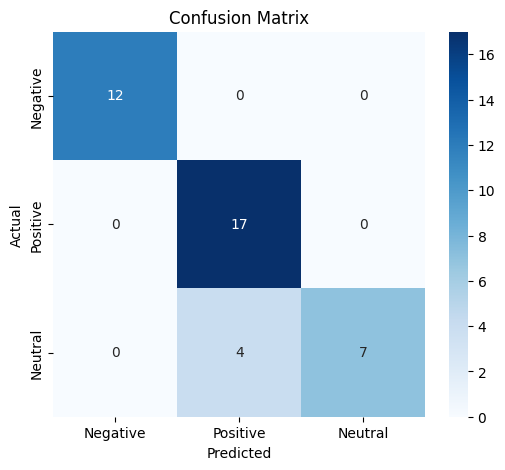

In [ ]:


model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 1. Accuracy
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(all_labels, all_preds)
print(f"\n✅ Validation Accuracy: {accuracy:.4f}")

# 2. Detailed Metrics
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=["Negative", "Positive", "Neutral"]))

# 3. Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Negative", "Positive", "Neutral"],
            yticklabels=["Negative", "Positive", "Neutral"])
plt.title("Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()


In [65]:
import torch.nn.functional as F


In [ ]:

df = pd.read_csv("bert_extracted_asp.csv")  
df = df.dropna(subset=['review', 'predicted_aspects'])

# Loading fine-tuned model
model_path = "bert_roberta_absa_manual"
model = RobertaForSequenceClassification.from_pretrained(model_path)
tokenizer = RobertaTokenizer.from_pretrained(model_path)
model.eval()
device = torch.device("cpu")
model = model.to(device)

def predict_sentiment_score(aspect, review):
    text = aspect + " [SEP] " + review
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
        probs = F.softmax(outputs.logits, dim=1).squeeze().cpu().numpy()
    return {
        "negative_score": float(probs[0]),
        "positive_score": float(probs[1]),
        "neutral_score": float(probs[2]),
        "predicted_label": ["negative", "positive", "neutral"][probs.argmax()]
    } 



results = df.apply(
    lambda row: predict_sentiment_score(str(row['predicted_aspects']), str(row['review'])),
    axis=1, result_type='expand'
)

df = pd.concat([df, results], axis=1)



In [70]:
df

,Unnamed: 0,userName,userImage,review,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,predicted_aspects,negative_score,positive_score,neutral_score,predicted_label
0,0,User_0,NaN,Good,5,0,4.556.10005,18-12-2024 17:17,NaN,NaN,4.556.10005,uber,0.000238,0.999529,0.000233,positive
1,1,User_1,NaN,Nice,5,0,4.556.10005,18-12-2024 17:17,NaN,NaN,4.556.10005,uber,0.000226,0.999524,0.000250,positive
2,2,User_2,NaN,Very convenient,5,0,4.532.10001,18-12-2024 17:09,NaN,NaN,4.532.10001,uber,0.000217,0.999006,0.000777,positive
3,3,User_3,NaN,Good,4,0,4.556.10005,18-12-2024 17:08,NaN,NaN,4.556.10005,uber,0.000238,0.999529,0.000233,positive
4,4,User_4,NaN,exllence,5,0,4.556.10005,18-12-2024 17:08,NaN,NaN,4.556.10005,uber,0.000725,0.000430,0.998845,neutral
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19054,19054,User_11999,NaN,"Very bad experience with this app, booked a sh...",1,0,NaN,24-11-2024 21:44,NaN,NaN,NaN,experience,0.999190,0.000512,0.000298,negative
19055,19055,User_11999,NaN,"Very bad experience with this app, booked a sh...",1,0,NaN,24-11-2024 21:44,NaN,NaN,NaN,"app,",0.999213,0.000483,0.000304,negative
19056,19056,User_11999,NaN,"Very bad experience with this app, booked a sh...",1,0,NaN,24-11-2024 21:44,NaN,NaN,NaN,problem,0.999217,0.000474,0.000308,negative
19057,19057,User_11999,NaN,"Very bad experience with this app, booked a sh...",1,0,NaN,24-11-2024 21:44,NaN,NaN,NaN,application.,0.999197,0.000501,0.000301,negative


In [ ]:
df.to_csv("bert_extracted_with_sentiment_score.csv", index=True)
